### Gold and Silver price prediction

In [1]:
import torch
import numpy as np
from torch import nn
import math, time
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import missingno as msno
import seaborn as sns
import gc

In [2]:
random_state=25
generator = torch.Generator().manual_seed(random_state)

### Steps
1. Data Pre-Processing
2. Feature Selection/Engineering
3. Model Test
4. Evaluation

In [3]:
silver_raw = pd.read_csv('datasets/Finance/Silver Futures Historical Data.csv')
gold_raw = pd.read_csv('datasets/Finance/Gold Futures Historical Data.csv')
copper_raw = pd.read_csv('datasets/Finance/Copper Futures Historical Data.csv')
palladium_raw = pd.read_csv('datasets/Finance/Palladium Futures Historical Data.csv')
platinum_raw = pd.read_csv('datasets/Finance/Platinum Futures Historical Data.csv')

In [9]:
print('silver', silver_raw.shape, 'gold', gold_raw.shape, 'copper', copper_raw.shape, 'palladium', palladium_raw.shape, 'platinum', platinum_raw.shape)
silver_raw.head()

silver (2605, 7) gold (2619, 7) copper (2612, 7) palladium (2878, 7) platinum (3137, 7)


,Date,Price,Open,High,Low,Vol.,Change %
0,02/28/2023,20.878,20.723,20.942,20.508,NaN,0.75%
1,02/27/2023,20.723,20.872,20.930,20.642,NaN,-0.73%
2,02/26/2023,20.875,20.855,20.942,20.850,NaN,0.31%
3,02/24/2023,20.810,21.330,21.395,20.725,51.63K,-2.33%
4,02/23/2023,21.306,21.520,21.670,21.260,52.99K,-1.71%


In [15]:
gold_raw['Price'] = gold_raw['Price'].str.replace(',', '').astype(float)
gold_raw['Price'] = gold_raw['Price'].str.replace(',', '').astype(float)
gold_raw['Price'] = gold_raw['Price'].str.replace(',', '').astype(float)
gold_raw['Price'] = gold_raw['Price'].str.replace(',', '').astype(float)

AttributeError: Can only use .str accessor with string values!

In [6]:
# Merge on Date
silver_gold = silver_raw.merge(gold_raw, on = 'Date', how = 'left', suffixes=('_silver', '_gold'))
# Format gold price, string -> float
silver_gold['Price_gold'] = silver_gold['Price_gold'].str.replace(',', '').astype(float)

In [7]:
# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
silver_gold[['Price_silver', 'Price_gold']] = scaler.fit_transform(silver_gold[['Price_silver', 'Price_gold']])

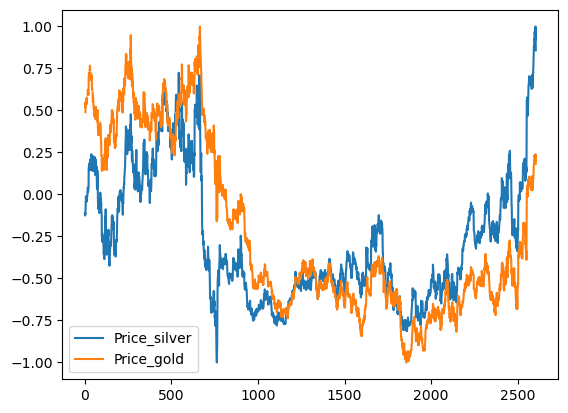

In [8]:
silver_gold[['Price_silver', 'Price_gold']].plot();

In [9]:
# Copy dataframe using loc
clean_df = silver_gold.loc[:, ['Date', 'Price_silver', 'Price_gold']]
print(clean_df['Date'][0])
clean_df['Date'] = pd.to_datetime(clean_df['Date'], format='%m/%d/%Y')
print(clean_df['Date'][0])

02/28/2023
2023-02-28 00:00:00


In [10]:
# 13 Missing values
clean_df.isnull().sum()

Date             0
Price_silver     0
Price_gold      13
dtype: int64

In [11]:
# Data imputation for missing gold prices with linear interpolation
clean_df['Price_gold'] = clean_df['Price_gold'].interpolate(method="linear")
print(clean_df.isnull().sum())

Date            0
Price_silver    0
Price_gold      0
dtype: int64


In [12]:
# Correlation of Silver and Gold
print(f"Correlation silver/gold: {clean_df['Price_silver'].corr(clean_df['Price_gold']):0.4f}")

Correlation silver/gold: 0.7544


In [13]:
# Dataset class
class MetalDataset(Dataset):
    def __init__(self, data, target):
        self.X = torch.tensor(data).float()
        self.y = torch.tensor(target).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx,:,:], self.y[idx,:]

In [14]:
# Train Test split with lookback for X
def split_data(data_raw, lookback, split):
    data = []
    
    for index in range(len(data_raw) - lookback + 1):
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round((1-split)*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [15]:
def batch_data(data_raw, lookback):
    data = []
    for index in range(len(data_raw) - lookback + 1):
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    
    x_ = data[:,:-1,:]
    y_ = data[:,-1,:]
    
    return [x_,y_]

In [16]:
seq_length=5
split=0.8

In [17]:
x_silver_data, y_silver_data = batch_data(clean_df['Price_silver'].to_numpy().reshape(-1, 1), seq_length)
x_silver_train, y_silver_train, x_silver_test, y_silver_test = split_data(clean_df['Price_silver'].to_numpy().reshape(-1, 1), seq_length, split)

In [18]:
# X = previous datapoints before the value in y.
print(x_silver_data[0], y_silver_data[0])
# A step in the future and shows the value in y from before.
print(x_silver_data[1], y_silver_data[0])

[[-0.1100904 ]
 [-0.12523821]
 [-0.11038358]
 [-0.11673589]] [-0.06826289]
[[-0.12523821]
 [-0.11038358]
 [-0.11673589]
 [-0.06826289]] [-0.06826289]


In [19]:
#Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [20]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(x.device)
        out, hn = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :]) 
        return out

In [23]:
def modelTrain(modelClass, df, seq_length = 5, split = 0.8, jumps = 2, hparams = (1,2,16,1,50,0.001)):
    # Shape Data
    
    # Ordered Data
    x_data, y_data = batch_data(df.to_numpy().reshape(-1, 1), seq_length)
    x_train, y_train, x_test, y_test = split_data(df.to_numpy().reshape(-1, 1), seq_length, split)
    
    dataset = MetalDataset(x_data, y_data)
    
    # Data Random Split
    train_len = int(len(dataset)*split)
    lens = [train_len, len(dataset)-train_len]
    train_ds, test_ds = random_split(dataset, lens, generator=generator)
    
    # Dataloaders
    trainloader = DataLoader(train_ds, batch_size=seq_length, shuffle=True, drop_last=True)
    testloader = DataLoader(test_ds, batch_size=seq_length, shuffle=True, drop_last=True)
    
    # Hyperparameters
    input_size, num_layers, hidden_size, output_size, num_epochs, learning_rate = hparams
    
    # Model
    model = modelClass(input_size, hidden_size, num_layers, output_size)
    
    # Loss function & Optimizer
    loss_fn = nn.MSELoss(reduction='mean').to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Performance data
    hist = np.zeros(num_epochs)
    hist_test = np.zeros(num_epochs)
    start_time = time.time()

    # Training loop
    model.to(device)
    
    for epoch in range(num_epochs):
        #Train
        model.train()

        for x, y in trainloader:
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            y_preds = model(x)

            # Calculate the loss
            loss = loss_fn(y_preds, y)
            hist[epoch] = loss.item()

            # Optimizer zero grad
            optimizer.zero_grad()

            # Loss backward
            loss.backward()

            # Step the optimizer
            optimizer.step()

        # Test
        model.eval()

        for x_t, y_t in testloader:
            with torch.inference_mode():
                x_t = x_t.to(device)
                y_t = y_t.to(device)
                y_test_preds = model(x_t)
                test_loss = loss_fn(y_test_preds, y_t)
                hist_test[epoch] = test_loss.item()

        if epoch % jumps == 0:
            print("Epoch ", epoch, 
                  f"MSE: {loss.item():.5f}", 
                  f"Test MSE: {test_loss.item():.5}")

    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    
    return model, hist, hist_test

In [25]:
# Hyperparameters
# input_size, num_layers, hidden_size, output_size, num_epochs, learning_rate
hyperparams = (1,2,16,1,50,0.001)
gru_model, hist, hist_test = modelTrain(GRU, clean_df['Price_silver'], seq_length, split, 10, hyperparams)

Epoch  0 MSE: 0.00085 Test MSE: 0.0015399
Epoch  10 MSE: 0.00237 Test MSE: 0.00089527
Epoch  20 MSE: 0.00113 Test MSE: 0.0014238
Epoch  30 MSE: 0.00052 Test MSE: 0.0010307
Epoch  40 MSE: 0.00096 Test MSE: 0.00022194
Training time: 35.82320547103882


In [26]:
#x_silver_train = torch.from_numpy(x_silver_train).type(torch.Tensor)
#y_silver_train = torch.from_numpy(y_silver_train).type(torch.Tensor)
x_silver_test = torch.from_numpy(x_silver_test).type(torch.Tensor)
y_silver_test = torch.from_numpy(y_silver_test).type(torch.Tensor)

gru_model.eval()
with torch.no_grad():
    y_preds = gru_model(x_silver_test.to(device))

In [27]:
scaler.fit_transform(silver_raw['Price'].to_numpy().reshape(-1, 1))
y_preds_df = pd.DataFrame(scaler.inverse_transform(y_preds.cpu().detach().numpy()))
y_silver_test_df = pd.DataFrame(scaler.inverse_transform(y_silver_test.numpy()))

In [28]:
def plotData(y_original, y_preds, hist, hist_test):
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    plt.subplot(1, 2, 1)
    ax = sns.lineplot(x = y_original.index, y = y_original[0], label="Original", color='royalblue')
    ax = sns.lineplot(x = y_preds.index, y = y_preds[0], label="Predicted", color='tomato')

    ax.set_title('GRU Silver Price Test', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (USD)", size = 14)
    ax.set_xticklabels('', size=10)

    plt.subplot(1, 2, 2)
    ax = sns.lineplot(data=hist, label="Loss", color='royalblue')
    ax = sns.lineplot(data=hist_test, label="Test Loss", color='green')
    ax.set_xlabel("Epoch", size = 14)
    ax.set_ylabel("Test Loss", size = 14)
    ax.set_title("Training Loss", size = 14, fontweight='bold')
    fig.set_figheight(6)
    fig.set_figwidth(16)

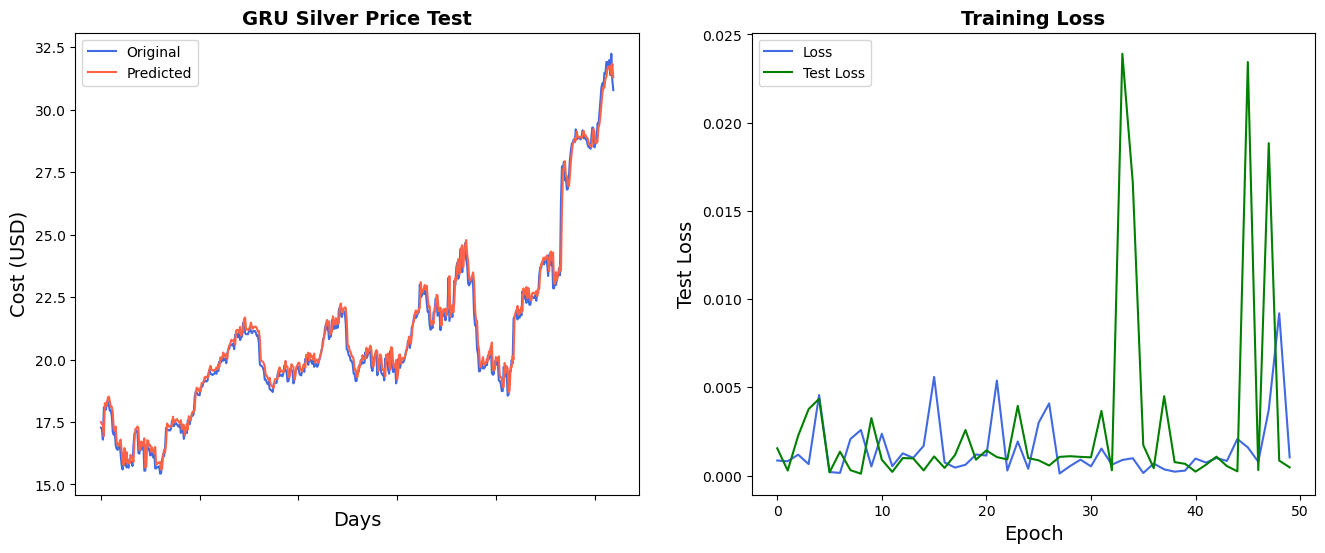

In [29]:
plotData(y_silver_test_df, y_preds_df, hist, hist_test)

In [30]:
# Predicted values get stacked in the data and re-iterates.
def futurePrediction(model, data, n_preds, seq_length):
    model.eval()
    x_data = data
    seq = seq_length - 1
    for i in range(n_preds):
        with torch.no_grad():
            y_preds = model(x_data.to(device))
            x_data = torch.cat((x_data.cpu(), y_preds[-seq:].reshape(1,seq,1).cpu()), 0)
        
    return y_preds

In [31]:
# I take out some days to compare original vs prediction of a window
y_preds = futurePrediction(gru_model, x_silver_test[:-5], 5, 5)

In [32]:
y_preds_df = pd.DataFrame(scaler.inverse_transform(y_preds.cpu().detach().numpy()))
y_silver_test_df = pd.DataFrame(scaler.inverse_transform(y_silver_test.numpy()))

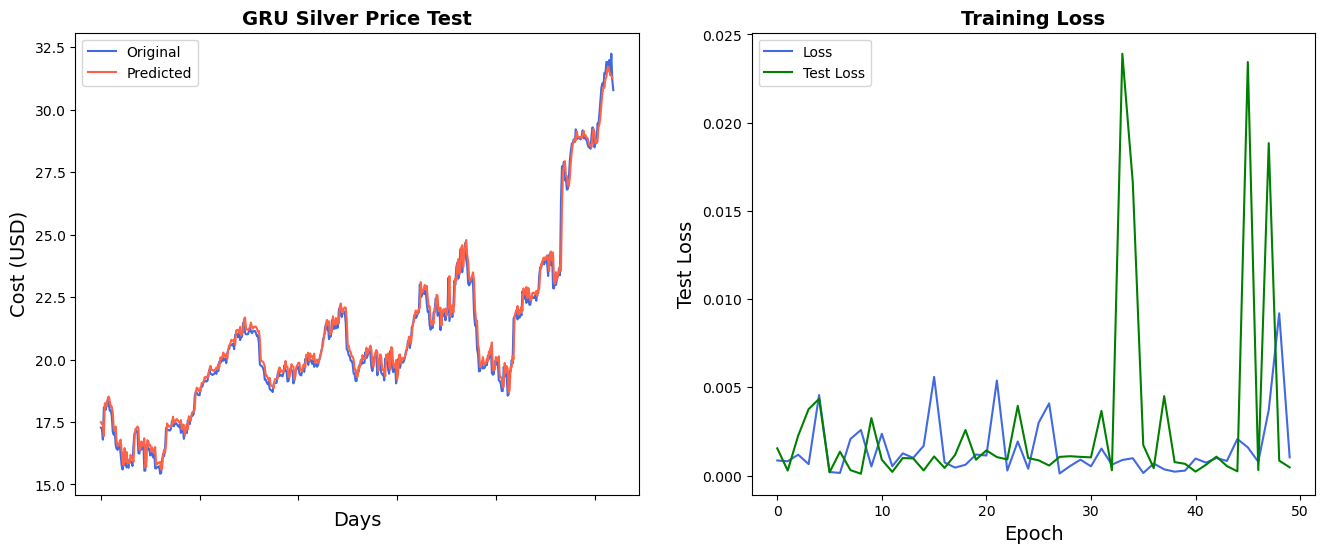

In [33]:
plotData(y_silver_test_df[:],y_preds_df[:], hist, hist_test)

In [34]:
# Wrap up
def runExperiment(GRU, df, seq_length, split, jumps, hyperparams):
    x_data, y_data = batch_data(df.to_numpy().reshape(-1, 1), seq_length)
    x_train, y_train, x_test, y_test = split_data(df.to_numpy().reshape(-1, 1), seq_length, split)
    
    model, hist, hist_test = modelTrain(GRU, df, seq_length, split, jumps, hyperparams)
    
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)
    
    y_preds = futurePrediction(model, x_test[:-seq_length], seq_length, seq_length)
    
    y_preds_df = pd.DataFrame(scaler.inverse_transform(y_preds.cpu().detach().numpy()))
    y_test_df = pd.DataFrame(scaler.inverse_transform(y_test.numpy()))
    
    plotData(y_test_df[:],y_preds_df[:], hist, hist_test)
    
    return model

Epoch  0 MSE: 0.00859 Test MSE: 0.01664
Epoch  10 MSE: 0.00108 Test MSE: 0.0012451
Epoch  20 MSE: 0.00160 Test MSE: 0.0015569
Epoch  30 MSE: 0.00221 Test MSE: 0.0012907
Epoch  40 MSE: 0.00088 Test MSE: 0.001043
Epoch  50 MSE: 0.00195 Test MSE: 0.00054867
Epoch  60 MSE: 0.00188 Test MSE: 0.0040618
Epoch  70 MSE: 0.00130 Test MSE: 0.00097417
Epoch  80 MSE: 0.00205 Test MSE: 0.00093619
Epoch  90 MSE: 0.00157 Test MSE: 0.0019835
Training time: 29.42788052558899


GRU(
  (gru): GRU(1, 32, num_layers=8, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

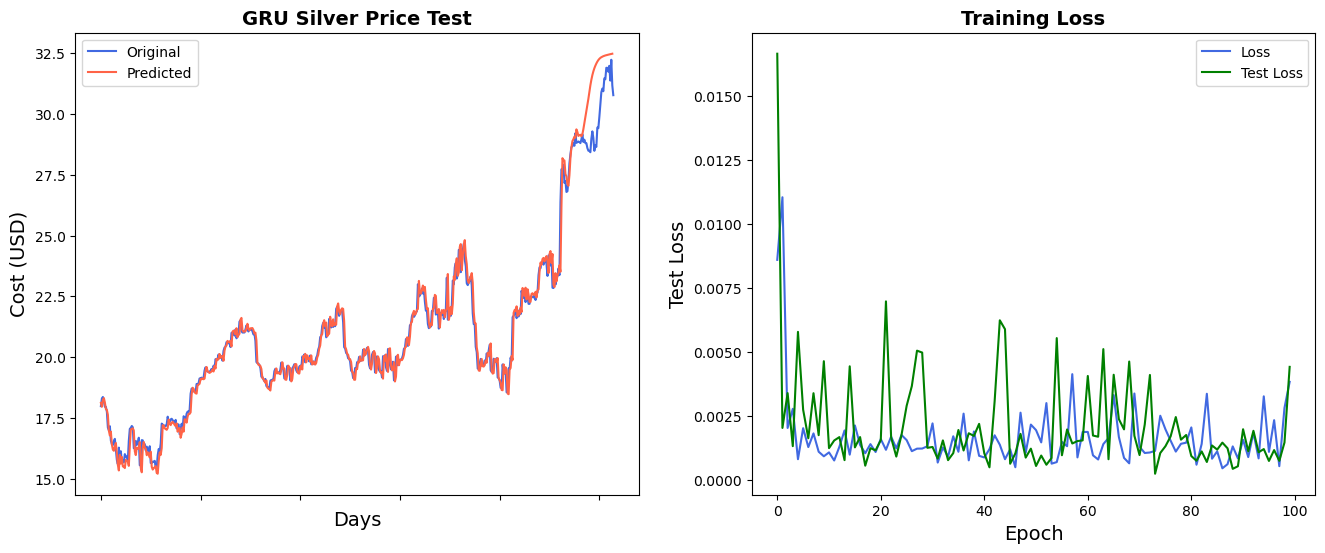

In [35]:
# input_size, num_layers, hidden_size, output_size, num_epochs, learning_rate
hyperparams = (1,8,32,1,100,0.001)
runExperiment(GRU, clean_df['Price_silver'], 30, 0.8, 10, hyperparams)

In [36]:
class GRU_Drop(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU_Drop, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(x.device)
        out, hn = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :]) 
        return out

Epoch  0 MSE: 0.01633 Test MSE: 0.014661
Epoch  10 MSE: 0.00712 Test MSE: 0.0060161
Epoch  20 MSE: 0.00519 Test MSE: 0.0038331
Epoch  30 MSE: 0.00264 Test MSE: 0.0018918
Epoch  40 MSE: 0.00266 Test MSE: 0.0021408
Epoch  50 MSE: 0.00595 Test MSE: 0.0010748
Epoch  60 MSE: 0.00690 Test MSE: 0.0038116
Epoch  70 MSE: 0.00091 Test MSE: 0.0013485
Epoch  80 MSE: 0.00124 Test MSE: 0.00097907
Epoch  90 MSE: 0.00303 Test MSE: 0.0021176
Epoch  100 MSE: 0.00201 Test MSE: 0.0017988
Epoch  110 MSE: 0.00147 Test MSE: 0.0020286
Epoch  120 MSE: 0.00269 Test MSE: 0.0023089
Epoch  130 MSE: 0.00169 Test MSE: 0.00096762
Epoch  140 MSE: 0.00207 Test MSE: 0.0036587
Epoch  150 MSE: 0.00301 Test MSE: 0.0019107
Epoch  160 MSE: 0.00106 Test MSE: 0.0019889
Epoch  170 MSE: 0.00244 Test MSE: 0.002227
Epoch  180 MSE: 0.00183 Test MSE: 0.002223
Epoch  190 MSE: 0.00276 Test MSE: 0.00098525
Epoch  200 MSE: 0.00281 Test MSE: 0.00236
Epoch  210 MSE: 0.00144 Test MSE: 0.0017764
Epoch  220 MSE: 0.00219 Test MSE: 0.0013308
E

GRU_Drop(
  (gru): GRU(1, 32, num_layers=8, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

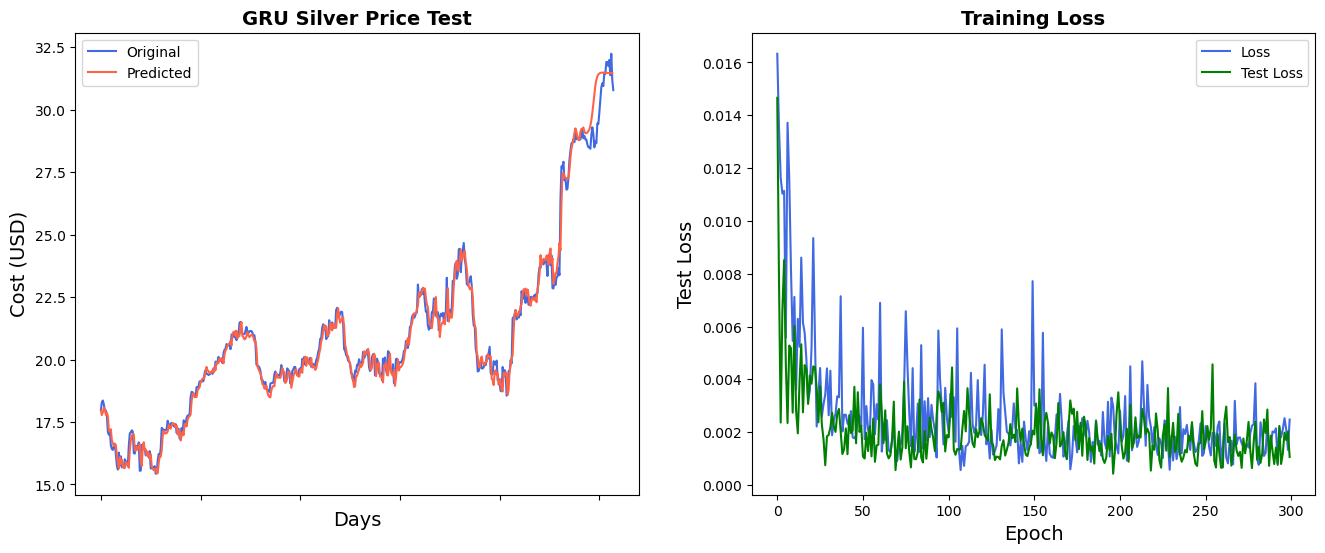

In [37]:
hyperparams = (1,8,32,1,300,0.001)
runExperiment(GRU_Drop, clean_df['Price_silver'], 30, 0.8, 10, hyperparams)

Epoch  0 MSE: 0.05535 Test MSE: 0.071174
Epoch  10 MSE: 0.00468 Test MSE: 0.0059755
Epoch  20 MSE: 0.00295 Test MSE: 0.0042367
Epoch  30 MSE: 0.00353 Test MSE: 0.0026853
Epoch  40 MSE: 0.00331 Test MSE: 0.002104
Training time: 30.02291703224182


GRU_Drop(
  (gru): GRU(1, 64, num_layers=16, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

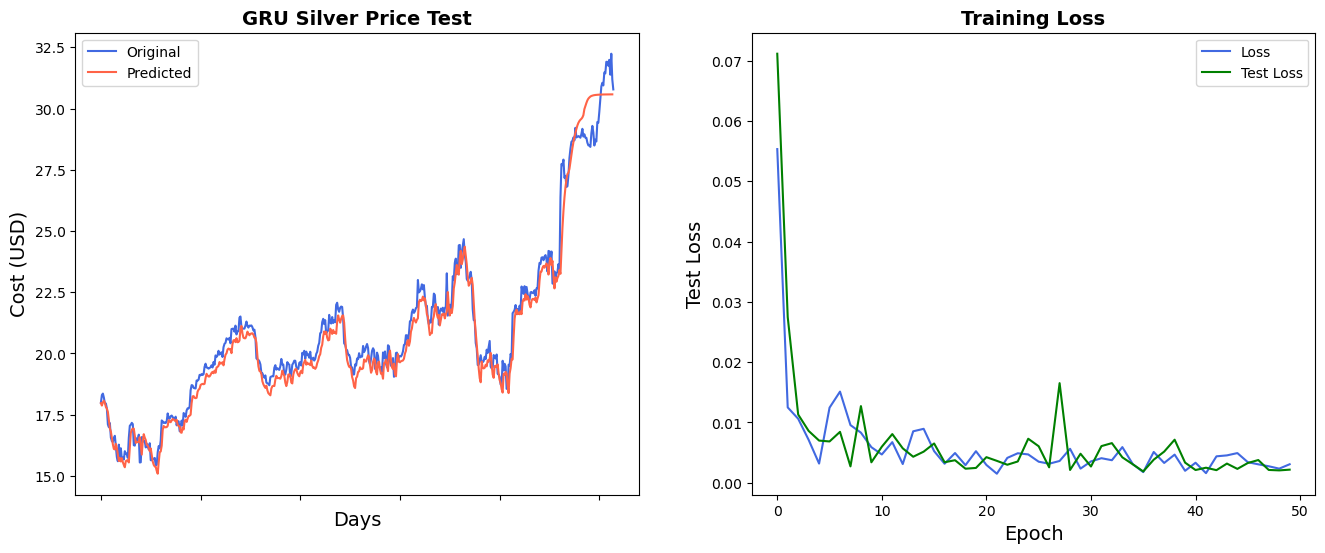

In [38]:
#Testing other parameters
hyperparams = (1,16,64,1,50,0.001)
runExperiment(GRU_Drop, clean_df['Price_silver'], 30, 0.8, 10, hyperparams)

In [39]:
# So as expected, the predictions only based on price are not very accurate and sometimes seems random.
# This is when the other metals and rates come into place to make consistent predictions.
# How can we make a prediction based on 2 different data sources? Let's see how data correlates.

In [40]:
# Merge on Date
metals_df = None
metals_df = pd.merge(silver_raw, gold_raw, on = 'Date', how = 'left', suffixes=('_silver', '_gold'))
metals_df = pd.merge(metals_df, copper_raw, on = 'Date', how = 'left', suffixes=('', '_copper'))
metals_df = pd.merge(metals_df, palladium_raw, on = 'Date', how = 'left', suffixes=('', '_palladium'))
metals_df = pd.merge(metals_df, platinum_raw, on = 'Date', how = 'left', suffixes=('', '_platinum'))
# Didn't change the suffix in copper
metals_df.rename(columns={'Price': 'Price_copper'}, inplace=True)

# Format gold price, string -> float
#metals_df['Price_gold'] = metals_df['Price_gold'].str.replace(',', '').astype(float)

In [41]:
metals_df[['Date', 'Price_silver', 'Price_gold', 'Price_copper', 'Price_palladium', 'Price_platinum']]

,Date,Price_silver,Price_gold,Price_copper,Price_palladium,Price_platinum
0,02/28/2023,20.878,"1,836.70",4.0895,"1,420.90",950.70
1,02/27/2023,20.723,"1,824.90",4.0110,"1,427.90",938.40
2,02/26/2023,20.875,NaN,NaN,NaN,911.25
3,02/24/2023,20.810,"1,809.20",3.9520,"1,387.70",907.60
4,02/23/2023,21.306,"1,818.80",4.0590,"1,430.70",945.20
...,...,...,...,...,...,...
2600,02/01/2013,31.988,"1,670.60",3.7915,756.30,"1,684.70"
2601,01/31/2013,31.380,"1,662.00",3.7395,743.80,"1,677.10"
2602,01/30/2013,32.237,"1,681.60",3.7580,749.30,"1,688.85"
2603,01/29/2013,31.184,"1,660.80",3.6915,751.10,"1,682.30"


In [42]:
metals_df[['Date', 'Price_silver', 'Price_gold', 'Price_copper', 'Price_palladium', 'Price_platinum']].isnull().sum()

Date                0
Price_silver        0
Price_gold         13
Price_copper       47
Price_palladium    12
Price_platinum      1
dtype: int64

In [43]:
if metals_df['Price_gold'].dtype != 'float64': 
    metals_df['Price_gold'] = metals_df['Price_gold'].str.replace(',', '').astype(float)
if metals_df['Price_copper'].dtype != 'float64': 
    metals_df['Price_copper'] = metals_df['Price_copper'].str.replace(',', '').astype(float)
if metals_df['Price_palladium'].dtype != 'float64': 
    metals_df['Price_palladium'] = metals_df['Price_palladium'].str.replace(',', '').astype(float)
if metals_df['Price_platinum'].dtype != 'float64': 
    metals_df['Price_platinum'] = metals_df['Price_platinum'].str.replace(',', '').astype(float)

metals_df['Price_gold'] = metals_df['Price_gold'].interpolate(method="linear")
metals_df['Price_copper'] = metals_df['Price_copper'].interpolate(method="linear")
metals_df['Price_palladium'] = metals_df['Price_palladium'].interpolate(method="linear")
metals_df['Price_platinum'] = metals_df['Price_platinum'].interpolate(method="linear")

In [44]:
metals_df[['Date', 'Price_silver', 'Price_gold', 'Price_copper', 'Price_palladium', 'Price_platinum']].isnull().sum()

Date               0
Price_silver       0
Price_gold         0
Price_copper       0
Price_palladium    0
Price_platinum     0
dtype: int64

In [46]:
# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
metals_df[['Price_silver', 'Price_gold', 'Price_copper', 'Price_palladium', 'Price_platinum']] = scaler.fit_transform(metals_df[['Price_silver', 'Price_gold', 'Price_copper', 'Price_palladium', 'Price_platinum']])

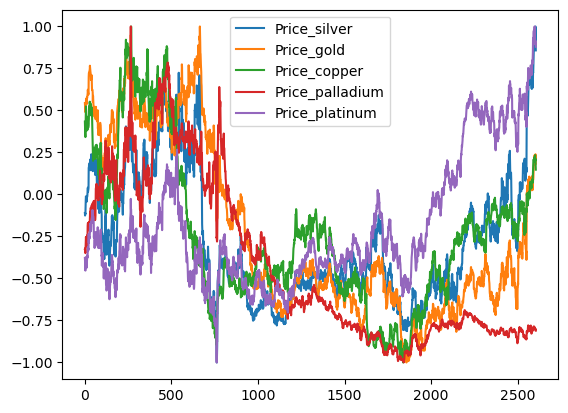

In [47]:
metals_df[['Price_silver', 'Price_gold', 'Price_copper', 'Price_palladium', 'Price_platinum']].plot();

In [48]:
metals_df[['Price_silver', 'Price_gold', 'Price_copper', 'Price_palladium', 'Price_platinum']].to_numpy().reshape(-1, 5).shape

(2605, 5)

In [49]:
x_data, y_data = batch_data(metals_df[['Price_silver', 'Price_gold', 'Price_copper', 'Price_palladium', 'Price_platinum']].to_numpy().reshape(-1, 5), seq_length)
x_data.shape

(2601, 4, 5)